In [1]:
from sys import path
path.append("../")
%matplotlib inline  
import matplotlib.pyplot as plt

<a id="coastline_classifier_top"></a>

# Coastline Classifier
This coastal boundary algorithm is used to classify a given pixel as either coastline or not coastline using a simple binary format like in the table before.  

<br>

$\begin{array}{|c|c|}
\hline
1& Coastline  \\ \hline
0& Not Coastline \\ \hline
\end{array}$

<br>  


The algorithm makes a classification by examining surrounding pixels and making a determination based on how many pixels around it are water  

<br>  

![img](diagrams/coastline_classification/b1.png)   
  
<br>

If the count of land pixels surrounding a pixel exceeds 5, then it's likely not coastline.
If the count of land pixels surrounding a pixel does not exceed 1, then it's likely not a coastline
  
<br>

$$
Classification(pixel) = \begin{cases} 
      1 & 2\le  count\_water\_surrounding(pixel)  \leq  5 \\
      0 & 
   \end{cases}
$$

<br>  
  
  
### Counting by applying a convolutional kernel  

A convolution applies a `kernel` to a point and it's surrounding pixels. Then maps the product to a new grid.  
  

![](http://colah.github.io/posts/2014-07-Understanding-Convolutions/img/RiverTrain-ImageConvDiagram.png)





In the case of coastal boundary classification, A convolution the following kernel is applied to a grid of `water`, `not-water` pixels.

<br>  


$$  
Kernel =
  \begin{bmatrix}
    1 & 1 & 1\\
    1 & 0 & 1\\  
    1 & 1 & 1\\
  \end{bmatrix}
$$  
  
<br>   
There exist more complicated differential kernels that would also work( see [sobel operator](https://en.wikipedia.org/wiki/Sobel_operator)).  
The one used in this notebooks operates on binary variables and is easier to work with and easy to debug. 

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#coastline_classifier_import)
* [Choose Platform and Product](#coastline_classifier_plat_prod)
* [Define the Extents of the Analysis](#coastline_classifier_define_extents)
* [Load Data from the Data Cube and Create a Composite](#coastline_classifier_retrieve_data)
* [Obtain Water Classifications and Coastal Change](#coastline_classifier_water_cls_and_coastal_change)

## <span id="coastline_classifier_import">Import Dependencies and Connect to the Data Cube [&#9652;](#coastline_classifier_top)</span>

In [2]:
import scipy.ndimage.filters as conv
import numpy as np

def _coastline_classification(dataset, water_band='wofs'):
    kern = np.array([[1, 1, 1], [1, 0.001, 1], [1, 1, 1]])
    convolved = conv.convolve(dataset[water_band], kern, mode='constant') // 1

    ds = dataset.where(convolved > 0)
    ds = ds.where(convolved < 6)
    ds.wofs.values[~np.isnan(ds.wofs.values)] = 1
    ds.wofs.values[np.isnan(ds.wofs.values)] = 0

    return ds.rename({"wofs": "coastline"})

In [3]:
import datacube
dc = datacube.Datacube(app = "Coastline classification")  

## <span id="coastline_classifier_plat_prod">Choose Platform and Product [&#9652;](#coastline_classifier_top)</span>

In [4]:
platform        = 'LANDSAT_8'
product_type    = 'ls8_usgs_sr_scene'

## <span id="coastline_classifier_define_extents">Define the Extents of the Analysis [&#9652;](#coastline_classifier_top)</span>

West Africa is subject to considerable coastal erosion in some areas. The links listed below are references regarding coastal erosion in West Africa and coastal erosion in general.  

- World Bank WACA program brochure (2015)  [- link](http://pubdocs.worldbank.org/en/622041448394069174/1606426-WACA-Brochure.pdf)
- USAID - Adapting to Coastal Climate Change (2009) -  [- link](http://www.crc.uri.edu/download/CoastalAdaptationGuide.pdf)  

In [5]:
# Ghana
lon = (0.0520, 0.3458)
lat = (5.6581, 5.8113)

**Visualize the selected area**

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(lat, lon)

## <span id="coastline_classifier_retrieve_data">Load Data from the Data Cube and Create a Composite [&#9652;](#coastline_classifier_top)</span>

In [7]:
from datetime import datetime 

params = dict(platform=platform,
              product=product_type,
              time=(datetime(2013,1,1), datetime(2013,12,31)) ,
              lon= lon,
              lat= lat,
              measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'] )


In [8]:
dataset = dc.load(**params)

**Obtain the clean mask**

In [9]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid

clean_mask = (landsat_qa_clean_mask(dataset, platform) &
             ((dataset != -9999).to_array().all('variable')) &
              landsat_clean_mask_invalid(dataset)).persist()

**Create a composite**

In [10]:
# from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

# def mosaic(dataset):
#     water_and_land_mask = landsat_qa_clean_mask(dataset, platform, 
#                                                 cover_types=['clear', 'water'])
#     return create_median_mosaic(dataset, clean_mask = water_and_land_mask)

In [11]:
# np.unique(clean_mask.red, return_counts=True)

In [12]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
from utils.data_cube_utilities.dc_utilities import ignore_warnings

composited_dataset = ignore_warnings(create_median_mosaic, dataset, clean_mask)

**Visualize Composited imagery** 

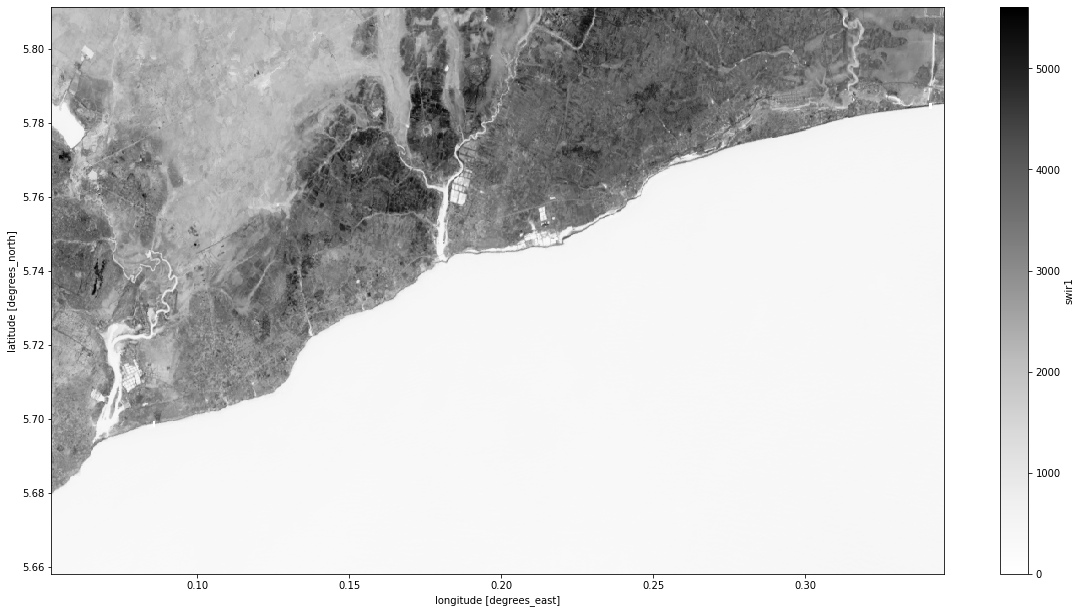

In [13]:
from utils.data_cube_utilities.plotter_utils import figure_ratio

composited_dataset.swir1.plot(cmap = "Greys", figsize = figure_ratio(dataset, fixed_width = 20))

## <span id="coastline_classifier_water_cls_and_coastal_change">Obtain Water Classifications and Coastal Change [&#9652;](#coastline_classifier_top)</span>

In [14]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

water_classification = ignore_warnings(wofs_classify, composited_dataset, mosaic = True)

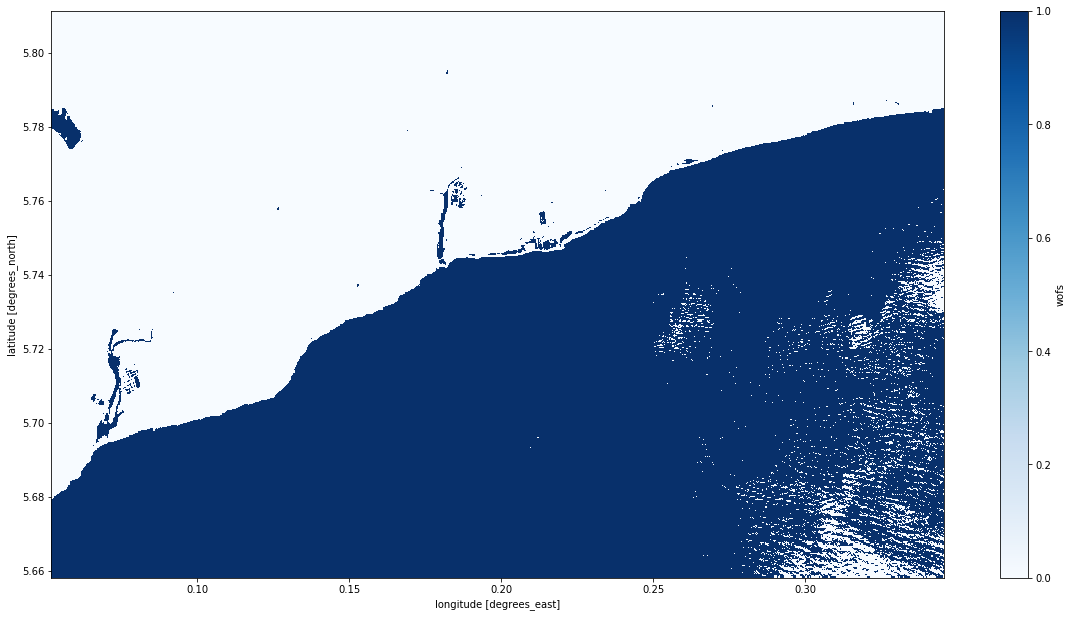

In [15]:
water_classification.wofs.plot(cmap = "Blues", figsize = figure_ratio(dataset, fixed_width = 20))

<br>

In [16]:
coast = _coastline_classification(water_classification, water_band='wofs')

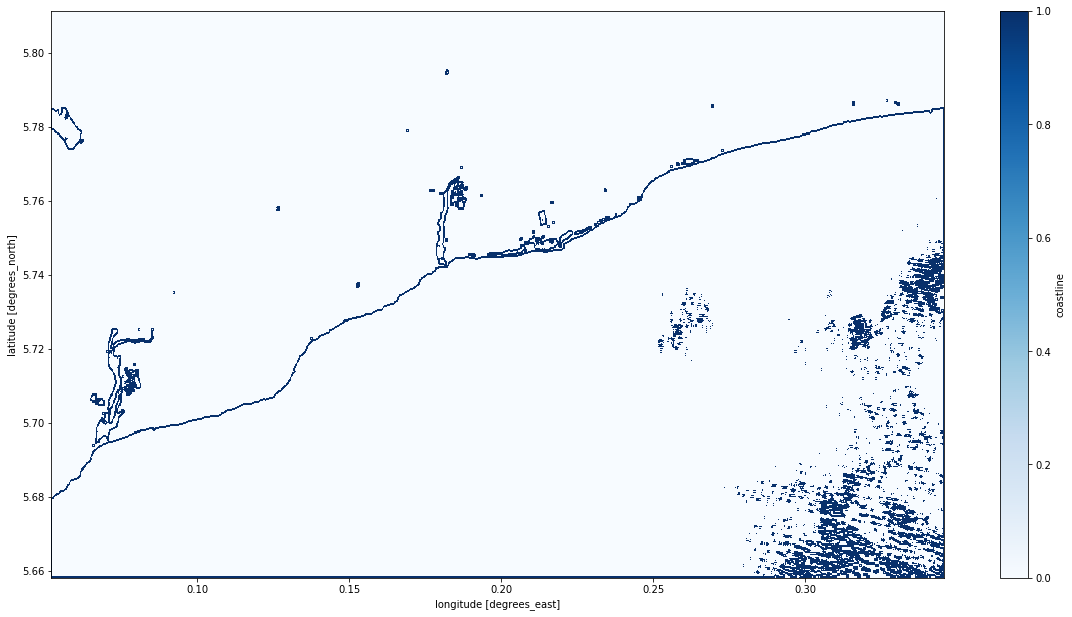

In [17]:
coast.coastline.plot(cmap = "Blues", figsize = figure_ratio(dataset, fixed_width = 20))